In [31]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import random
import netCDF4 as nc
from scipy.spatial import cKDTree
import seaborn as sns  

In [ ]:
#SINMOD features first :-) 

In [2]:
#Load transformed (SINMOD grid) coral data
coral_filepath = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_sinmod_grid.parquet'
coral_data = pd.read_parquet(coral_filepath)

coral_x = coral_data['x']
coral_y = coral_data['y']

In [3]:
#Load SINMOD data 
filename_sinmod = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

sinmod_data = Dataset(filename_sinmod, 'r')


In [33]:
#Load data for stat. northness and eastness
filename_jan_jun = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

jan_jun_data = Dataset(filename_jan_jun, 'r')


In [43]:
#Now plot a histogram for a chosen feature at coral data points 

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, jan_jun_data=False, current_aspect_angle=False, generate_random=False):
    
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    #Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            #Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                elif variable_name in ['statistical_eastness', 'statistical_northness']:
                    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                    longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                    theta = longitude_at_point - longitude_of_projection_origin
                    eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                    northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                    aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                    if variable_name == 'statistical_eastness':
                        value = np.sin(aspect)
                    else:
                        value = np.cos(aspect)
                        
                elif variable_name == 'current_aspect_angle':
                    try:
                        value = current_aspect_angle.variables[int(y), int(x)]
                    except KeyError:
                        value = np.nan  

                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))

    #Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    #Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    #Plot histogram of the combined variable values

    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_coral_points.png')
 

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        #Plotting histogram at random locations
        
        no_points = 100000

        #Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    random_depth = random.uniform(100, depth_at_point)
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                    elif variable_name in ['statistical_eastness', 'statistical_northness']:
                        longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                        longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                        if variable_name == 'statistical_eastness':
                            value = np.sin(aspect)
                        else:
                            value = np.cos(aspect)
                            
                    elif variable_name == 'current_aspect_angle':
                        try:
                            value = current_aspect_angle.variables[int(y), int(x)]
                        except KeyError:
                            value = np.nan  
                       
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        #Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        #Flatten the array to combine all time steps
        random_values_flat = random_values.copy().flatten()

        #Plot histogram at random points
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}', fontsize = 14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.show()
        #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_random_points.png')

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        #Calculate statistics for coral values
        stats = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10),
            'std': np.std(coral_values_flat, ddof=1), #std
            'cv': np.std(coral_values_flat, ddof=1) / np.mean(coral_values_flat) if np.mean(coral_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for coral values: {stats}")


        #Histogram of coral and random points combined
        bin_edges = np.histogram_bin_edges(np.concatenate([random_values_flat, coral_values_flat]), bins=40)
        plt.figure(figsize=(10, 6))
        plt.hist(random_values_flat, bins=bin_edges, edgecolor='black', color='red', alpha=0.6, label='Random Points')
        plt.hist(coral_values_flat, bins=bin_edges, edgecolor='black', color='blue', alpha=0.6, label='Coral Points')
        plt.legend(loc='upper right')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Frequency', fontsize=14) 
        plt.title(f'Combined Histogram of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()


        #KDE line plots for both random and coral points combined
        plt.figure(figsize=(10, 6))
        sns.kdeplot(random_values_flat, color='red', lw=2, label='Random Points')
        sns.kdeplot(coral_values_flat, color='blue', lw=2, label='Coral Points')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Density', fontsize=14)  
        plt.title(f'KDE of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()
    return coral_values, random_values


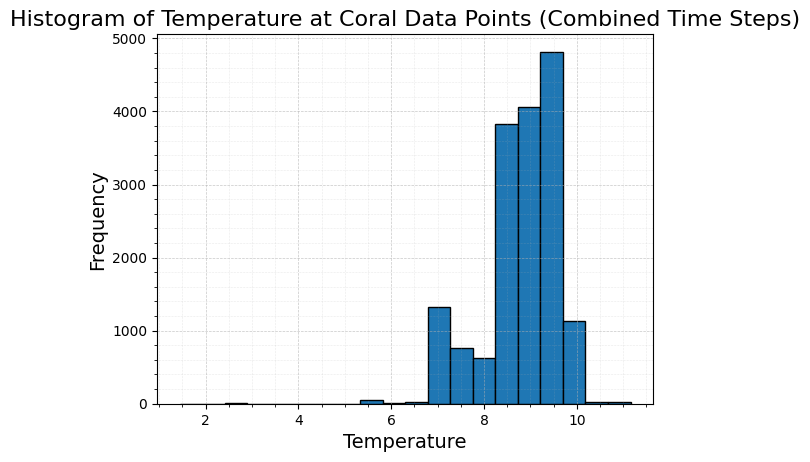

Number of valid coordinates: 836.0 out of 1718


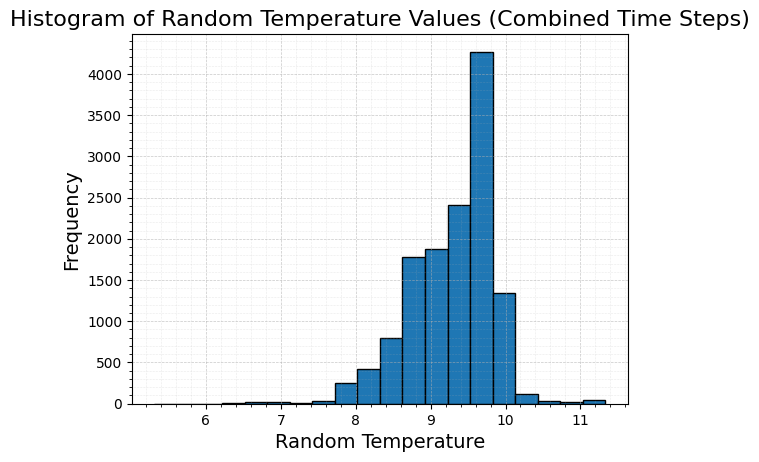

Number of valid random coordinates: 672.1 out of 1718
Statistics for coral values: {'mean': np.float32(8.807966), 'max': np.float32(11.155919), 'min': np.float32(1.4389477), '90th_percentile': np.float32(9.649098), '10th_percentile': np.float32(7.44084), 'std': np.float32(0.8146678), 'cv': np.float32(0.09249216)}


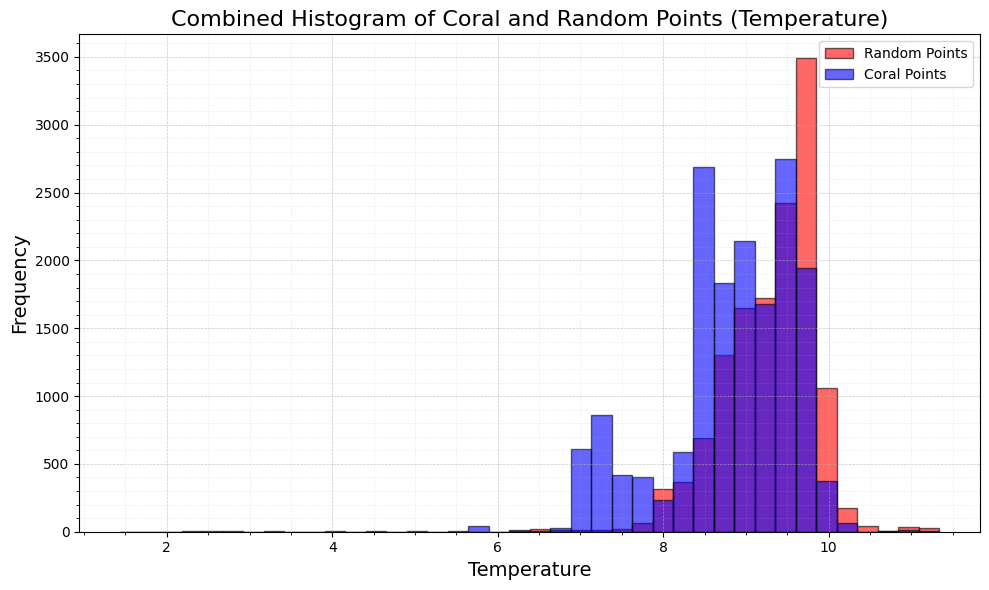

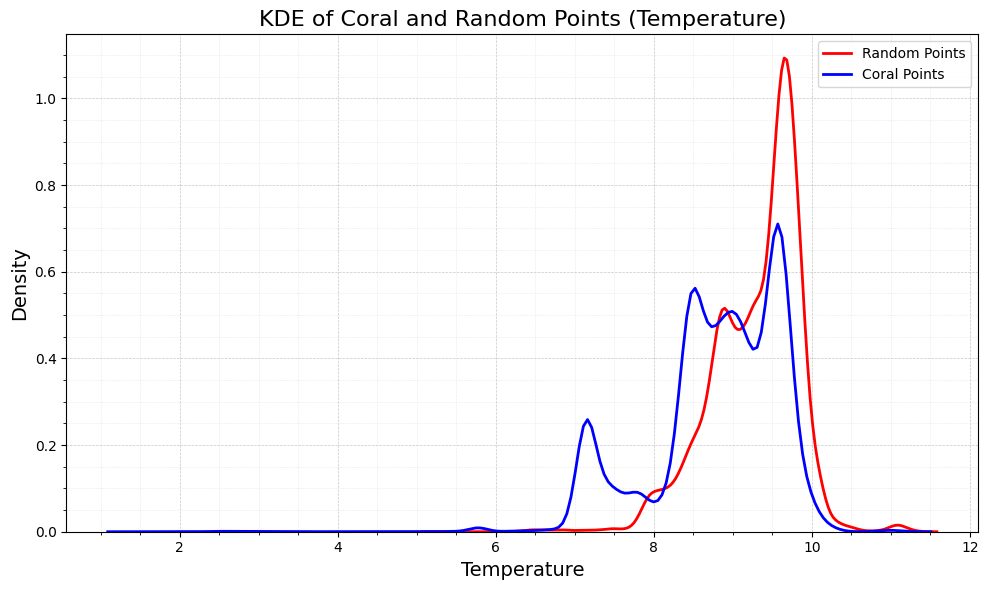

In [44]:
#Plot histograms for desired features
#tmax = len(sinmod_data.variables['time'])
#tmax = 20

#coral_values_salinity, random_values_salinity = plot_histogram_at_coral_points(sinmod_data, coral_data, 'salinity', (0, tmax), False, False, True)
#coral_values_stat_north, random_values_stat_northness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_northness', (0, tmax), jan_jun_data, False, True)
#coral_values_stat_eastness, random_values_stat_eastness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_eastness', (0, tmax), jan_jun_data, False, True)
#coral_values_current_speed, random_values_current_speed = plot_histogram_at_coral_points(sinmod_data, coral_data, 'current_speed', (0, tmax), False, False, True)
coral_values_temperature, random_values_temperature = plot_histogram_at_coral_points(sinmod_data, coral_data, 'temperature', (0, tmax), False, False, True)



In [40]:
#Box plots 
def plot_comparison_boxplots(coral_values, random_values, variable_name):
    
    data = [coral_values, random_values]
    labels = ['Coral Values', 'Random Values']

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, tick_labels=labels)
    plt.xticks(fontsize=14) 
    plt.ylabel(variable_name.capitalize(), fontsize=14)
    plt.title(f'Comparison of {variable_name.capitalize()} at Coral Data Points and Random Locations', fontsize=16)
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Control grid appearance
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/boxplots/{variable_name}_comparison_boxplot.png')
    plt.show()


In [ ]:
#Plot boxplots for desired features
#plot_comparison_boxplots(coral_values_salinity, random_values_salinity, 'salinity')
#plot_comparison_boxplots(coral_values_stat_north, random_values_stat_north, 'statistical_northness')
#plot_comparison_boxplots(coral_values_stat_eastness, random_values_stat_eastness, 'statistical_eastness')
#plot_comparison_boxplots(coral_values_current_speed, random_values_current_speed, 'current_speed')
#plot_comparison_boxplots(coral_values_temperature, random_values_temperature, 'temperature')

In [ ]:
#Next EMOD features

In [37]:
#Load transformed (EMOD grid) coral data
coral_filepath_emod = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_emod_grid.parquet'
coral_data_emod = pd.read_parquet(coral_filepath_emod)

coral_x_emod = coral_data_emod['x']
coral_y_emod = coral_data_emod['y']

In [38]:
print(coral_data_emod.head())

               x             y
0  541563.035108  7.183257e+06
1  574769.093767  7.053834e+06
2  448510.482064  7.072666e+06
3  518562.649871  7.129859e+06
4  475671.223693  7.111198e+06


In [39]:
#Load EMOD data
#emod_data = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/EMOD_features.nc")
emod_data = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc")
emod_data_copy = emod_data.copy()

In [3]:
print(list(emod_data_copy.variables))

['x', 'y', 'aspect_cos', 'aspect_sin', 'bathymetry_32N_Clip_sample', 'broad_BPI_std', 'fine_BPI_std', 'log_ruggedness_1', 'slope']


In [40]:
#Handle the EMOD data 
emod_df = emod_data_copy.to_dataframe()
emod_df = emod_df.reset_index()
emod_df['y'] = emod_df['y'].round().astype(int)
emod_df['x'] = emod_df['x'].round().astype(int)
emod_df = emod_df.set_index(['y', 'x'])
nan_indices = emod_df[emod_df['bathymetry_32N_Clip_sample'].isna()].index
emod_df_cleaned = emod_df.dropna(subset=['bathymetry_32N_Clip_sample'])
emod_df = emod_df_cleaned.sort_values(by="y")

In [34]:
#Current aspect angle
#sinmod_bottom = xr.open_dataset('/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/SINMOD_bottom_features.nc')
sinmod_bottom = xr.open_dataset("/cluster/home/maikents/features_midnor_2019/ready_for_training/SINMOD_bottom_features_emod_grid2.nc")

current_aspect_angle = sinmod_bottom['current_aspect_angle']

In [16]:
current_df = current_aspect_angle.to_dataframe()

NameError: name 'current_aspect_angle' is not defined

In [ ]:
current_df_cleaned = current_df.dropna(subset=['current_aspect_angle'])


In [58]:
def permutation_test(x, y, num_permutations=100000):
    observed_diff = np.mean(x) - np.mean(y)
    combined = np.concatenate([x, y])
    count = 0

    #Perform permutations
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_x = combined[:len(x)]
        new_y = combined[len(x):]
        new_diff = np.mean(new_x) - np.mean(new_y)
        if abs(new_diff) >= abs(observed_diff):
            count += 1
    
    p_value_permutation = count / num_permutations
    return observed_diff, p_value_permutation

In [64]:
#Histograms for EMOD data

import scipy.stats as stats  
import numpy as np
from decimal import Decimal

def plot_histogram_at_coral_points_emod(emod_df, coral_data, variable_name, generate_random=False):
    
    coral_values = []
    valid_coords = []
    xc_max = 692028
    yc_max = 7539188
    x_indices = np.clip(np.round(coral_data['x']).astype(int), -65456, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y']).astype(int), 6659218, yc_max - 1)

    emod_df.index = emod_df.index.map(lambda index: (round(index[0]), round(index[1])))

    df_y_values = np.array(emod_df.index.get_level_values(0))
    df_x_values = np.array(emod_df.index.get_level_values(1))

    for x, y in zip(x_indices, y_indices):
    
        if (y, x) in emod_df.index:
            closest_y, closest_x = y, x
        else:
            # Find the closest available indices in df
            closest_y = df_y_values[np.abs(df_y_values - y).argmin()]
            closest_x = df_x_values[np.abs(df_x_values - x).argmin()]

        if (closest_y, closest_x) in emod_df.index:
            value = emod_df.loc[(closest_y, closest_x)][variable_name]
            if not np.ma.is_masked(value):
                if (closest_y, closest_x) not in valid_coords:
                    coral_values.append(value)
                    valid_coords.append((closest_y, closest_x))

    coral_values_flat = np.ravel(coral_values)
    values = pd.DataFrame({f'{variable_name}': coral_values_flat})

    values = values[variable_name].dropna().values

    print(f"Number of valid coordinates: {len(valid_coords)} out of {len(coral_data)}")

    if len(values) == 0:
        print("Error: array is empty after dropping NaNs!")
    else:

        #Calculate statistics for coral values
        stats_coral = {
            'mean': np.mean(values),
            'max': np.max(values),
            'min': np.min(values),
            '90th_percentile': np.percentile(values, 90),
            '10th_percentile': np.percentile(values, 10),
            'std': np.std(values, ddof=1), #std
            'cv': np.std(values, ddof=1) / np.mean(values) if np.mean(values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }
       
        print(f"Statistics for {variable_name}:", stats_coral)


    if generate_random:
        no_points = int(len(values))  

        variable_data = emod_df[variable_name]
        valid_data = variable_data.dropna()
        random_indices = np.random.choice(valid_data.index, no_points, replace=False)
        random_values = emod_df.loc[random_indices, variable_name]

        #Calculate statistics for coral values
        random_stats = {
            'mean': np.mean(random_values),
            'max': np.max(random_values),
            'min': np.min(random_values),
            '90th_percentile': np.percentile(random_values, 90),
            '10th_percentile': np.percentile(random_values, 10),
            'std': np.std(random_values, ddof=1), #std
            'cv': np.std(random_values, ddof=1) / np.mean(random_values) if np.mean(random_values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for random values: {random_stats}")
        
        # Mann-Whitney U Test
        u_stat, p_value = stats.mannwhitneyu(values, random_values, alternative='two-sided')
        print(f"Mann-Whitney U statistic: {u_stat}")
        print(f"p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference between coral points and random points is statistically significant (p < 0.05).")
        else:
            print(f"There is no statistically significant difference between coral points and random points (p >= 0.05).")
        
        # Calculate effect size (Cliff’s delta for Mann-Whitney)
        cliff_delta = np.mean(values > np.median(random_values)) - np.mean(random_values > np.median(values))
        print(f"Cliff’s delta: {cliff_delta}")

        # KS Test
        statistic, p_value_ks = stats.ks_2samp(values, random_values)
        print(f"KS Statistic: {statistic}")
        print(f"P-value: {p_value_ks}")
        
        # Interpretation for KS Test
        if p_value_ks < 0.05:
            print("There is a significant difference between the two distributions (ks).")
        else:
            print("There is no significant difference between the two distributions (ks).")

        from scipy.stats import ttest_ind

        # Perform independent t-test
        t_stat, p_value_ttest = ttest_ind(values, random_values)
        
        print(f"T-test statistic: {t_stat}")
        print(f"T-test p-value: {p_value_ttest}")
        
        if p_value_ttest < 0.05:
            print("The difference between coral points and random points is statistically significant (t-test).")
        else:
            print("There is no statistically significant difference between coral points and random points (t-test).")


        
        # Run permutation test
        observed_diff, p_value_permutation = permutation_test(values, random_values)
        p_value_permutation_rounded = Decimal(p_value_permutation)

        
        print(f"Observed Difference in Means: {observed_diff}")
        print(f"Permutation Test p-value: {p_value_permutation_rounded:.20f}")
        
        if p_value_permutation < 0.05:
            print("The difference between coral points and random points is statistically significant (Permutation Test).")
        else:
            print("There is no statistically significant difference between coral points and random points (Permutation Test).")



        from scipy.stats import gaussian_kde

        #plt.figure(figsize=(10, 6))

 
        kde_coral = gaussian_kde(values)
        kde_random = gaussian_kde(random_values)

        x = np.linspace(min(values.min(), random_values.min()),
                        max(values.max(), random_values.max()), 1000)
         
        coral_density = kde_coral(x)
        random_density = kde_random(x)
   
        from scipy.stats import gaussian_kde

        #plt.figure(figsize=(10, 6))

 
        kde_coral = gaussian_kde(values)
        kde_random = gaussian_kde(random_values)

        x = np.linspace(min(values.min(), random_values.min()),
                        max(values.max(), random_values.max()), 1000)
         
        coral_density = kde_coral(x)
        random_density = kde_random(x)
        ratio = coral_density / (random_density + 1e-10)
        area = np.trapz(ratio, x)
        normalized_ratio = ratio / area
    

        plt.figure(figsize=(10, 6))

        plt.plot(x, coral_density, label='Coral KDE', color='blue')
        plt.plot(x, random_density, label='Random KDE', color='red')
        plt.plot(x, normalized_ratio, label='Normalized Density Ratio', color='green')
        plt.grid(which='both', linestyle='--', color='gray')


        plt.legend()
        plt.title(f"KDE of Coral Points, Random Points, and Normalized Coral to Random Density Ratio ({variable_name})", fontsize=16)
        plt.xlabel(f'{variable_name}', fontsize=14)  # You can change 'X-Values' to a variable name if needed


        plt.show()




        

      


    return values, random_values




In [25]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_histogram_at_coral_points_and_all_points_emod(emod_df, coral_data, variable_name, generate_random=False):
    
    coral_values = []
    valid_coords = []
    xc_max = 692028
    yc_max = 7539188
    x_indices = np.clip(np.round(coral_data['x']).astype(int), -65456, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y']).astype(int), 6659218, yc_max - 1)

    # Adjust dataframe indices for searching
    emod_df.index = emod_df.index.map(lambda index: (round(index[0]), round(index[1])))
    df_y_values = np.array(emod_df.index.get_level_values(0))
    df_x_values = np.array(emod_df.index.get_level_values(1))

    # Collect coral values
    for x, y in zip(x_indices, y_indices):
        if (y, x) in emod_df.index:
            closest_y, closest_x = y, x
        else:
            # Find the closest available indices in df
            closest_y = df_y_values[np.abs(df_y_values - y).argmin()]
            closest_x = df_x_values[np.abs(df_x_values - x).argmin()]

        if (closest_y, closest_x) in emod_df.index:
            value = emod_df.loc[(closest_y, closest_x)][variable_name]
            if not np.ma.is_masked(value):
                if (closest_y, closest_x) not in valid_coords:
                    coral_values.append(value)
                    valid_coords.append((closest_y, closest_x))

    coral_values_flat = np.ravel(coral_values)
    values = pd.DataFrame({f'{variable_name}': coral_values_flat})
    values = values[variable_name].dropna().values

    # Plot histogram of the combined variable values at coral points
    bin_edges = np.histogram_bin_edges(values, bins=20)
    plt.hist(values, bins=bin_edges, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()

    print(f"Number of valid coral coordinates: {len(valid_coords)} out of {len(coral_data)}")

    # Calculate statistics for coral values
    stats_coral = {
        'mean': np.mean(values),
        'max': np.max(values),
        'min': np.min(values),
        '90th_percentile': np.percentile(values, 90),
        '10th_percentile': np.percentile(values, 10),
        'std': np.std(values, ddof=1),  # Standard deviation
        'cv': np.std(values, ddof=1) / np.mean(values) if np.mean(values) != 0 else np.nan  # Coefficient of Variation
    }
    print(f"Statistics for coral points ({variable_name}):", stats_coral)

    # Collect all model area values (for the entire grid)
    model_values = []
    for y in range(yc_max):
        for x in range(xc_max):
            if (y, x) in emod_df.index:
                value = emod_df.loc[(y, x)][variable_name]
                if not np.ma.is_masked(value):
                    model_values.append(value)

    model_values_flat = np.array(model_values)

    # Plot histogram for all grid points (model area)
    plt.hist(model_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()} (Model Area)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at All Model Points', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()

    print(f"Number of model area coordinates: {len(model_values_flat)}")

    # Calculate statistics for model values
    stats_model = {
        'mean': np.mean(model_values_flat),
        'max': np.max(model_values_flat),
        'min': np.min(model_values_flat),
        '90th_percentile': np.percentile(model_values_flat, 90),
        '10th_percentile': np.percentile(model_values_flat, 10),
        'std': np.std(model_values_flat, ddof=1),  # Standard deviation
        'cv': np.std(model_values_flat, ddof=1) / np.mean(model_values_flat) if np.mean(model_values_flat) != 0 else np.nan  # Coefficient of Variation
    }
    print(f"Statistics for model area points ({variable_name}):", stats_model)

    # Mann-Whitney U Test (to compare coral points vs model area points)
    u_stat, p_value = stats.mannwhitneyu(values, model_values_flat, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {u_stat}")
    print(f"p-value: {p_value}")

    if p_value < 0.05:
        print(f"The difference between coral points and model area points is statistically significant (p < 0.05).")
    else:
        print(f"There is no statistically significant difference between coral points and model area points (p >= 0.05).")

    
    # KDE plot for both coral points and model area points
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, color='blue', lw=2, label='Coral Points')
    sns.kdeplot(model_values_flat, color='green', lw=2, label='Model Area Points')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'KDE of Coral and Model Area Points ({variable_name.capitalize()})', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Return values
    return values, model_values_flat


Number of valid coordinates: 718 out of 841
Statistics for bathymetry_32N_Clip_sample: {'mean': np.float64(-294.5530173240598), 'max': np.float64(-18.350322723388672), 'min': np.float64(-714.1312866210938), '90th_percentile': np.float64(-199.84502410888672), '10th_percentile': np.float64(-372.22083740234376), 'std': np.float64(80.40298147423798), 'cv': np.float64(-0.27296607654770905)}
Statistics for random values: {'mean': np.float32(-679.65454), 'max': np.float32(0.0), 'min': np.float32(-2850.409), '90th_percentile': np.float32(-110.11018), '10th_percentile': np.float32(-1605.1344), 'std': np.float32(631.6563), 'cv': np.float32(-0.9293785)}
Mann-Whitney U statistic: 340875.0
p-value: 3.7684080032515406e-26
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.584958217270195
KS Statistic: 0.42618384401114207
P-value: 7.151988478421493e-59
There is a significant difference between the two distributions (ks).
T-test statistic: 1

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


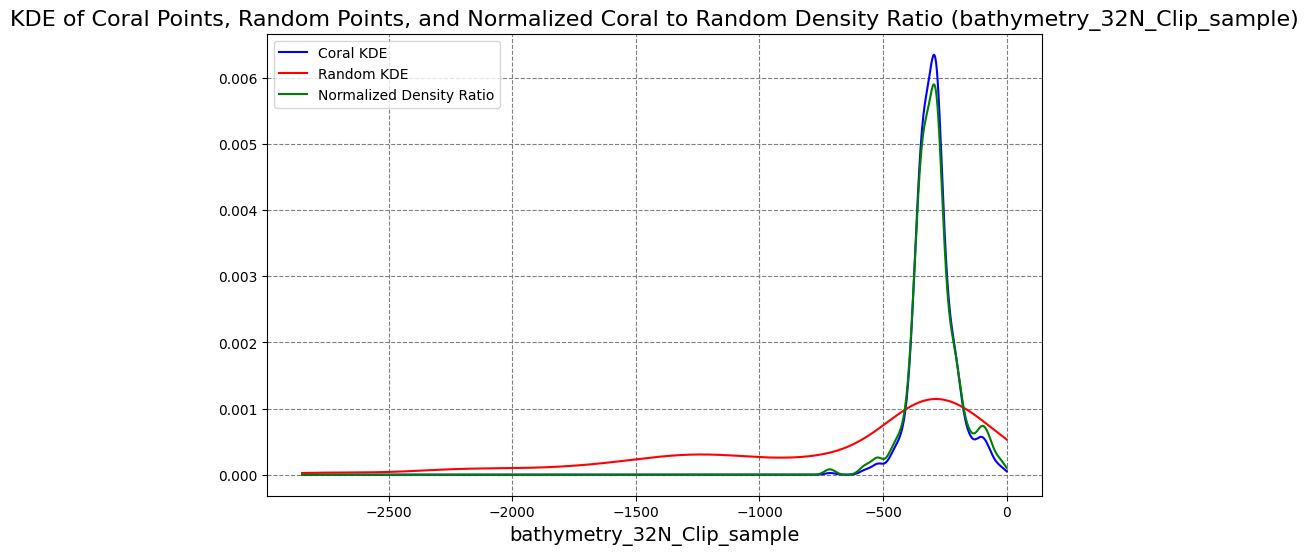

In [65]:
#Repeat for desired features

#values_chlor_a, random_values_chlor_a = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'chlor_a', chlor_a, True)
values_bathymetry, random_values_bathymetry = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'bathymetry_32N_Clip_sample',True)


Number of valid coordinates: 718 out of 841
Statistics for aspect_cos: {'mean': np.float64(-0.09288723331703512), 'max': np.float64(0.9999837875366211), 'min': np.float64(-0.999980092048645), '90th_percentile': np.float64(0.9366859555244446), '10th_percentile': np.float64(-0.9724753499031067), 'std': np.float64(0.7232563914769918), 'cv': np.float64(-7.786391796259365)}
Statistics for random values: {'mean': np.float64(0.19625588963500232), 'max': np.float64(0.9999969005584717), 'min': np.float64(-0.9999999403953552), '90th_percentile': np.float64(0.9769723415374756), '10th_percentile': np.float64(-0.8766674518585205), 'std': np.float64(0.6649435014328635), 'cv': np.float64(3.3881454598357723)}
Mann-Whitney U statistic: 197664.0
p-value: 1.1562543906050881e-13
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: -0.35104895104895106
KS Statistic: 0.22237762237762237
P-value: 6.715853164582781e-16
There is a significant difference 

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


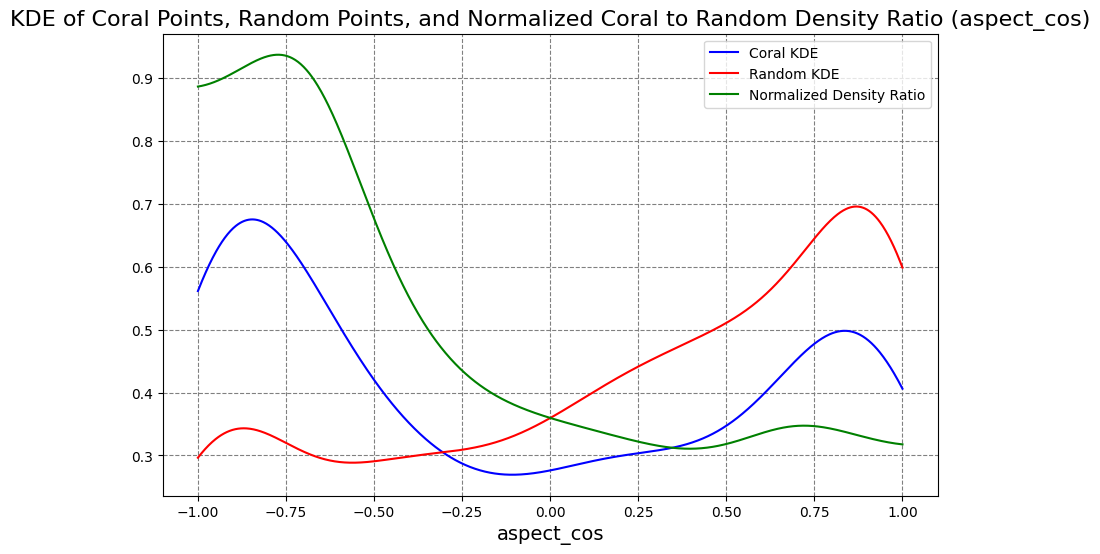

In [66]:
values_aspect_cos, random_values_aspect_cos = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'aspect_cos',True)


Number of valid coordinates: 718 out of 841
Statistics for aspect_sin: {'mean': np.float64(-0.17915710491499492), 'max': np.float64(1.0), 'min': np.float64(-0.9999998807907104), '90th_percentile': np.float64(0.8340409755706787), '10th_percentile': np.float64(-0.9647203683853149), 'std': np.float64(0.661451741366246), 'cv': np.float64(-3.692020708193998)}
Statistics for random values: {'mean': np.float64(-0.1376443443228849), 'max': np.float64(0.999980092048645), 'min': np.float64(-0.9999971389770508), '90th_percentile': np.float64(0.8834196329116821), '10th_percentile': np.float64(-0.9747642397880554), 'std': np.float64(0.6797837491266512), 'cv': np.float64(-4.938697281539011)}
Mann-Whitney U statistic: 248267.0
p-value: 0.3468521968644198
There is no statistically significant difference between coral points and random points (p >= 0.05).
Cliff’s delta: -0.07412587412587407
KS Statistic: 0.06853146853146853
P-value: 0.06958429653871431
There is no significant difference between the two

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


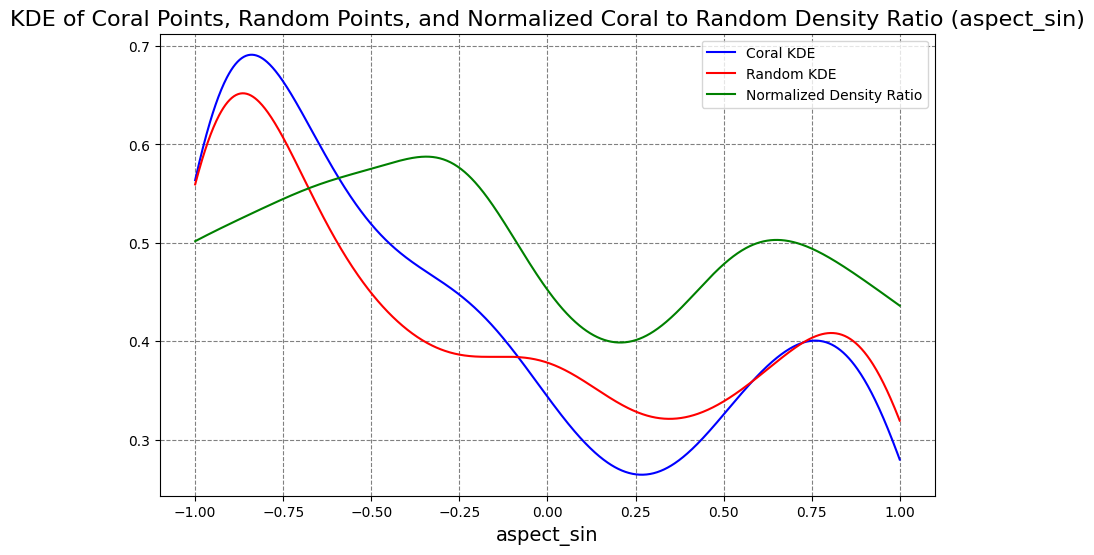

In [67]:
values_aspect_sin, random_values_aspect_sin = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'aspect_sin',True)


Number of valid coordinates: 718 out of 841
Statistics for broad_BPI_std: {'mean': np.float64(5.747910863509749), 'max': np.float64(574.0), 'min': np.float64(-623.0), '90th_percentile': np.float64(128.20000000000027), '10th_percentile': np.float64(-159.79999999999998), 'std': np.float64(138.07510827667483), 'cv': np.float64(24.021790099988497)}
Statistics for random values: {'mean': np.float64(-2.715877437325905), 'max': np.float64(839.0), 'min': np.float64(-1172.0), '90th_percentile': np.float64(44.0), '10th_percentile': np.float64(-41.0), 'std': np.float64(102.80712764064546), 'cv': np.float64(-37.85411161332485)}
Mann-Whitney U statistic: 313442.0
p-value: 1.3146105897301615e-12
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.41086350974930363
KS Statistic: 0.2799442896935933
P-value: 3.5635185917673866e-25
There is a significant difference between the two distributions (ks).
T-test statistic: 1.317442214656415
T-test p

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


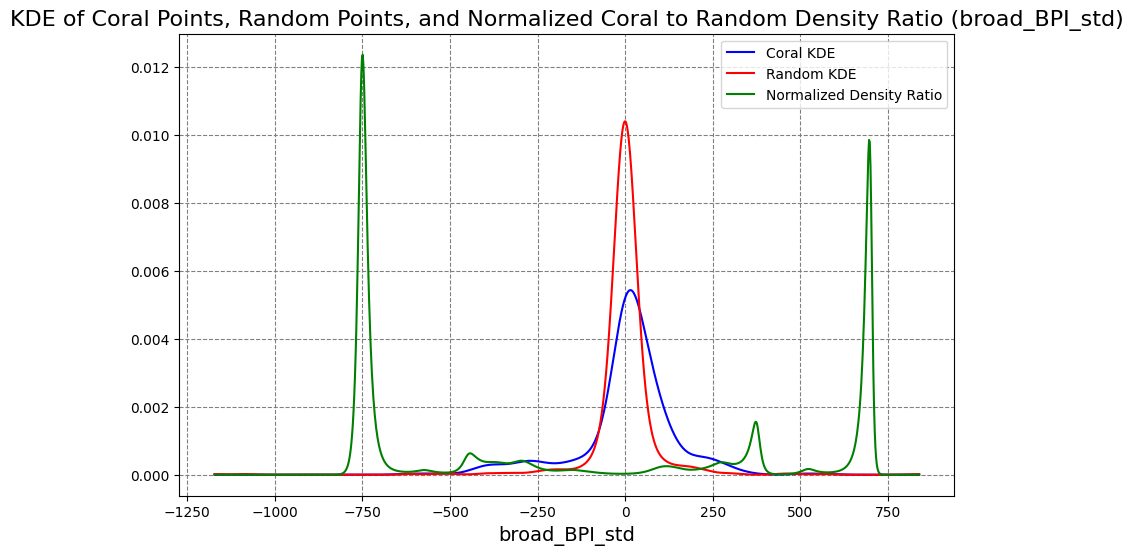

In [70]:
values_broad_BPI, random_values_broad_BPI = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'broad_BPI_std', True)

Number of valid coordinates: 718 out of 841
Statistics for fine_BPI_std: {'mean': np.float64(20.764623955431755), 'max': np.float64(1075.0), 'min': np.float64(-834.0), '90th_percentile': np.float64(155.0), '10th_percentile': np.float64(-67.69999999999997), 'std': np.float64(162.85146187619577), 'cv': np.float64(7.8427359063054904)}
Statistics for random values: {'mean': np.float64(2.632311977715877), 'max': np.float64(1817.0), 'min': np.float64(-860.0), '90th_percentile': np.float64(31.0), '10th_percentile': np.float64(-21.0), 'std': np.float64(123.68666788953136), 'cv': np.float64(46.98784526173731)}
Mann-Whitney U statistic: 326978.5
p-value: 2.2143855298977414e-19
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.47075208913649025
KS Statistic: 0.3426183844011142
P-value: 9.374527989834791e-38
There is a significant difference between the two distributions (ks).
T-test statistic: 2.3759025995942786
T-test p-value: 0.01763

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


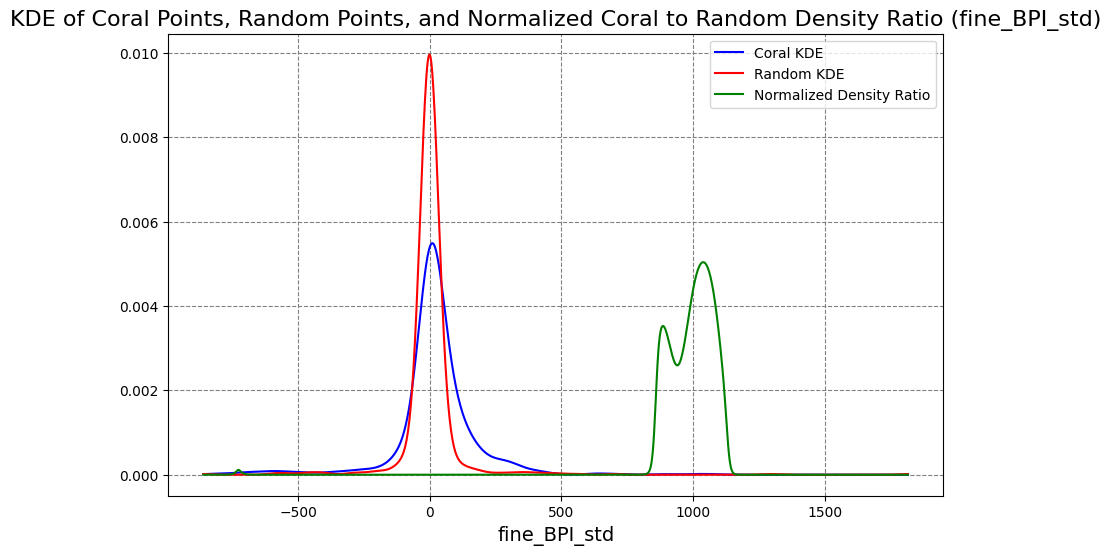

In [71]:
values_fine_BPI, random_values_fine_BPI = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'fine_BPI_std', True)

Number of valid coordinates: 718 out of 841
Statistics for log_ruggedness_1: {'mean': np.float64(-9.3405597123595), 'max': np.float64(0.0), 'min': np.float64(-15.942384719848633), '90th_percentile': np.float64(-5.983283710479736), '10th_percentile': np.float64(-12.820226287841797), 'std': np.float64(2.826955972008207), 'cv': np.float64(-0.302653808664973)}
Statistics for random values: {'mean': np.float32(-10.698819), 'max': np.float32(0.0), 'min': np.float32(-15.942385), '90th_percentile': np.float32(0.0), '10th_percentile': np.float32(-15.026094), 'std': np.float32(4.5549283), 'cv': np.float32(-0.42574123)}
Mann-Whitney U statistic: 348791.5
p-value: 4.764461590472317e-31
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.5571030640668524
KS Statistic: 0.35236768802228413
P-value: 5.875037654755519e-40
There is a significant difference between the two distributions (ks).
T-test statistic: 6.789046075787198
T-test p-value: 1

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


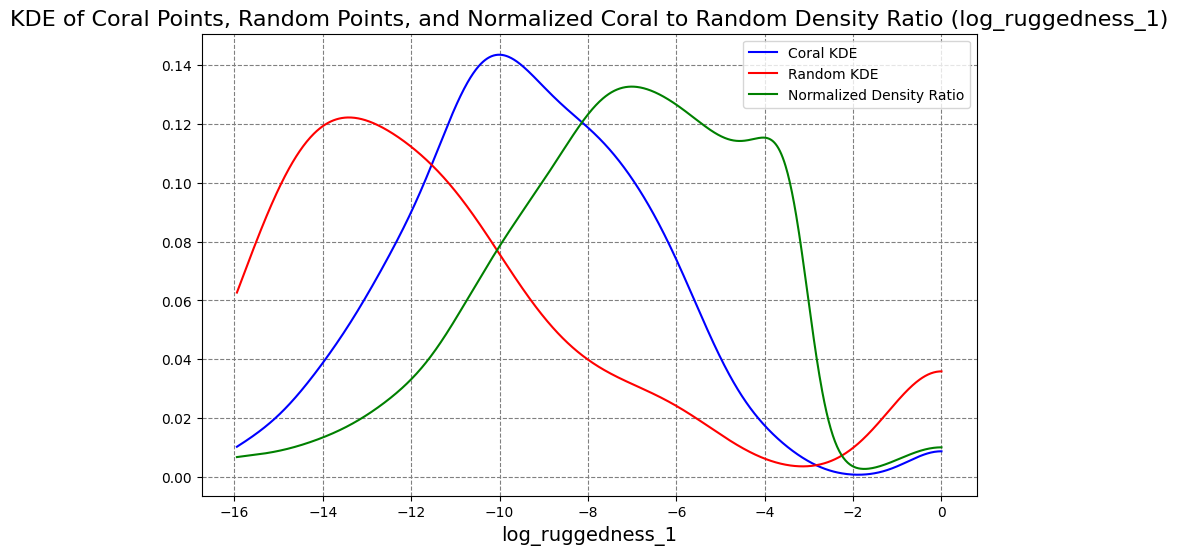

In [69]:
values_log_ruggedness, random_values_log_ruggedness = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'log_ruggedness_1', True)

Number of valid coordinates: 718 out of 841
Statistics for slope: {'mean': np.float64(3.123740909168097), 'max': np.float64(58.217594146728516), 'min': np.float64(0.0), '90th_percentile': np.float64(6.76164999008179), '10th_percentile': np.float64(0.3241235792636871), 'std': np.float64(5.473476216303822), 'cv': np.float64(1.7522183738860395)}
Statistics for random values: {'mean': np.float64(1.410481512953077), 'max': np.float64(33.988887786865234), 'min': np.float64(0.0), '90th_percentile': np.float64(2.903263092041017), '10th_percentile': np.float64(0.11235865205526352), 'std': np.float64(2.9671421938979905), 'cv': np.float64(2.1036377766382675)}
Mann-Whitney U statistic: 358252.0
p-value: 1.8059579435696724e-39
The difference between coral points and random points is statistically significant (p < 0.05).
Cliff’s delta: 0.5356643356643357
KS Statistic: 0.3230769230769231
P-value: 2.1106960327022326e-33
There is a significant difference between the two distributions (ks).
T-test stati

/tmp/ipykernel_194153/4162788785.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(ratio, x)


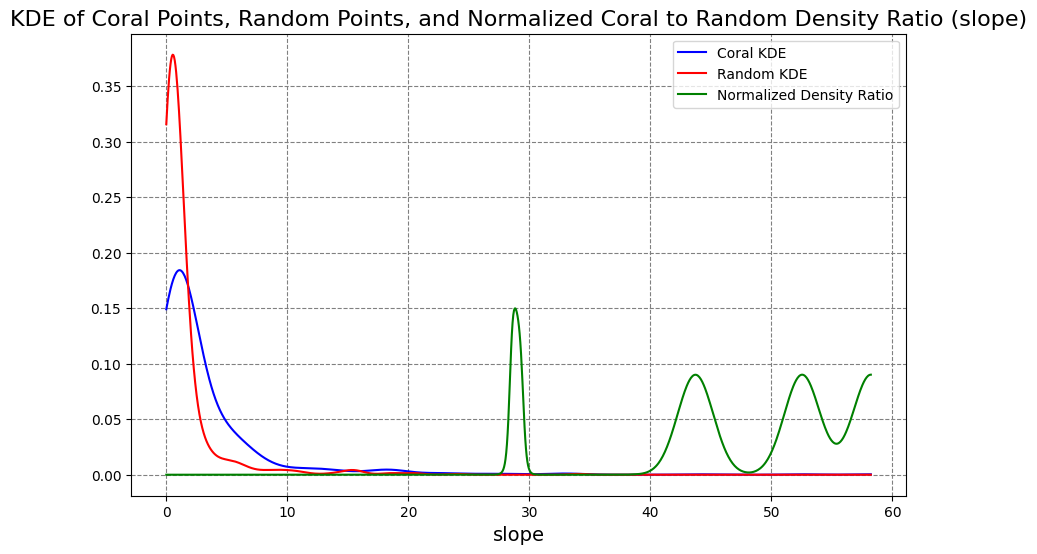

In [68]:
values_slope, random_values_slope = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'slope', True)

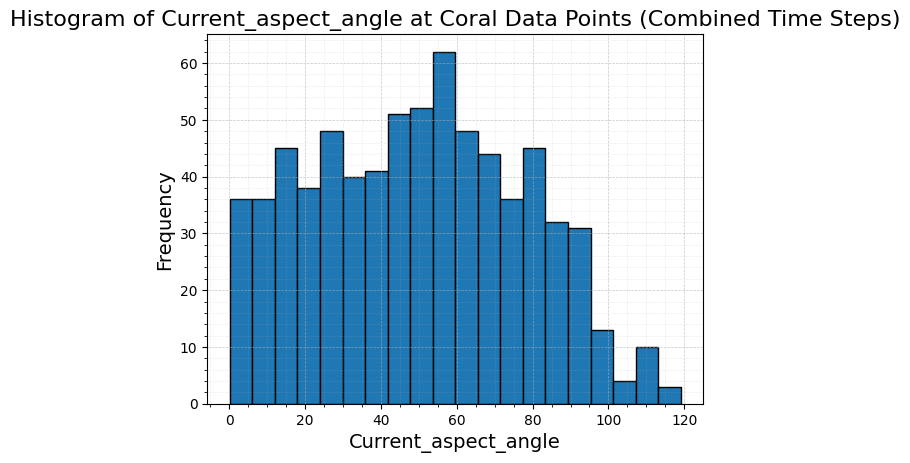

Number of valid coordinates: 715 out of 841
Statistics for current_aspect_angle: {'mean': np.float64(49.792551015287), 'max': np.float64(119.04370735908456), 'min': np.float64(0.18736109645549717), '90th_percentile': np.float64(86.68523178229196), '10th_percentile': np.float64(12.047915805344477), 'std': np.float64(27.644093004328667), 'cv': np.float64(0.555185312675415)}


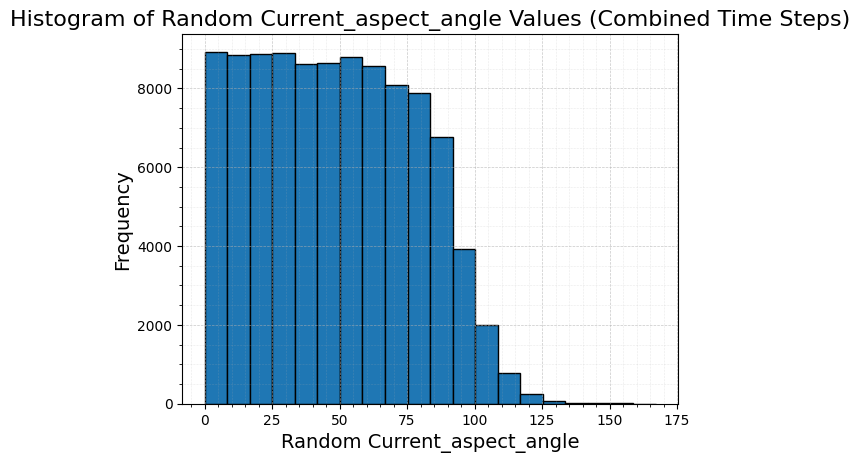

Statistics for random values: {'mean': np.float64(48.37087847440763), 'max': np.float64(167.04682144986012), 'min': np.float64(0.000766651430982072), '90th_percentile': np.float64(87.95890549173764), '10th_percentile': np.float64(9.341033749688538), 'std': np.float64(29.098492860233872), 'cv': np.float64(0.6015704857547601)}
Mann-Whitney U statistic: 36886224.5
p-value: 0.14244754153944306
There is no statistically significant difference between coral points and random points (p >= 0.05).


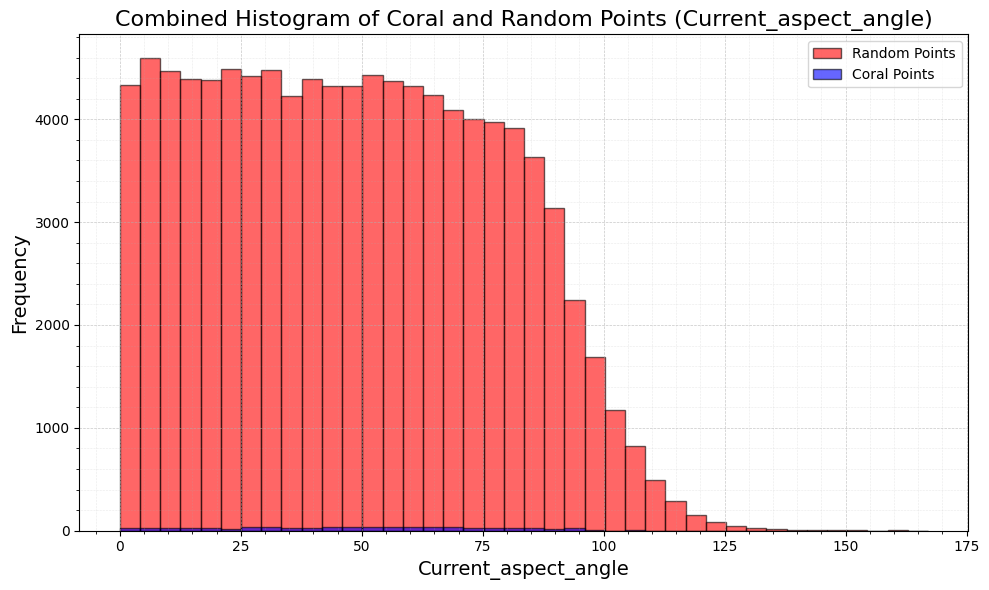

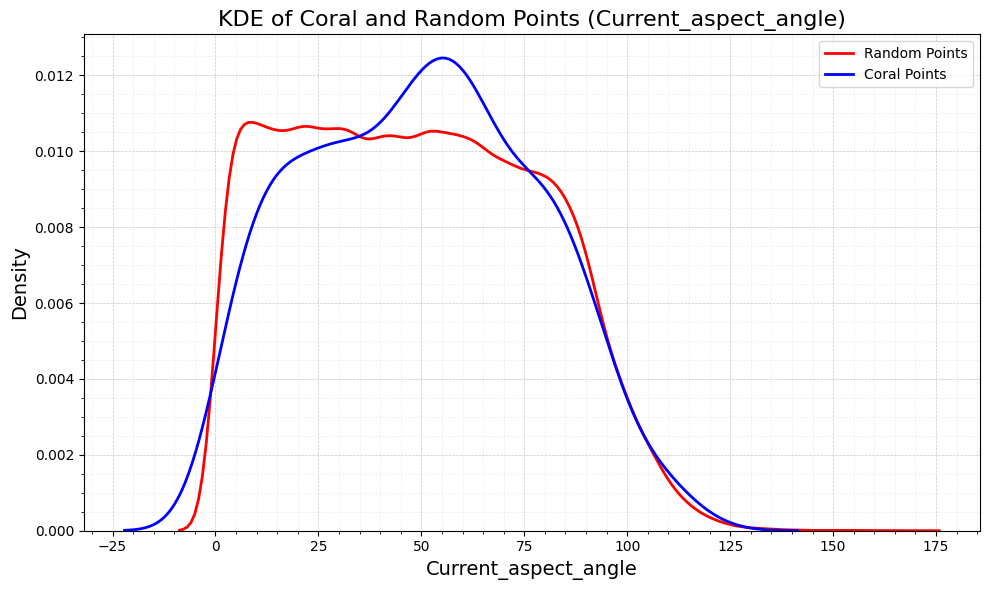

In [28]:
values_current_aspect_angle, random_values_current_aspect_angle= plot_histogram_at_coral_points_emod(current_df_cleaned, coral_data_emod, 'current_aspect_angle', True)